### 0. 필요한 라이브러리 Import

In [1]:
import os
import pandas as pd
import pandas_profiling
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from gensim.models.word2vec import Word2Vec
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

import kss
#from konlpy.tag import Kkma  
from konlpy.tag import Twitter
from eunjeon import Mecab
from konlpy.tag import Okt

# %appdata%\nltk_data\corpora\stopwords
# korean 파일을 생성하여 복사함
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

np.random.seed(42)

twitter = Twitter()
#kkma = Kkma()
mecab = Mecab('/usr/local/etc/mecabrc')
okt = Okt()


# 한글출력
matplotlib.rc('font', family='AppleGothic')  # MacOS
#matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

### 1. 통합된 원본 데이터 파일을 읽어온다

In [2]:

ROOT_DIR = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
dataset = pd.read_csv(os.path.join(ROOT_DIR, "dataset/one.csv"))

print(dataset.shape)
print(dataset.info())

(50568, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50568 entries, 0 to 50567
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   제목                              50568 non-null  object 
 1   저자                              50568 non-null  object 
 2   발행기관                            50568 non-null  object 
 3   학술지명                            50568 non-null  object 
 4   권호사항                            50568 non-null  object 
 5   발행연도                            50568 non-null  int64  
 6   작성언어                            50568 non-null  object 
 7   주제어                             26933 non-null  object 
 8   KDC                             11761 non-null  float64
 9   등재정보                            13083 non-null  object 
 10  자료형태                            50568 non-null  object 
 11  발행기관 URL                        22715 non-null  object 
 12  수록면                 

In [3]:
dataset.head()

,제목,저자,발행기관,학술지명,권호사항,발행연도,작성언어,주제어,KDC,등재정보,...,발행기관 URL,수록면,KCI 피인용횟수,비고,중단사유,제공처,소장기관,국문 초록 (Abstract),다국어 초록 (Multilingual Abstract),목차
0,전기 이륜자동차 분류기준 현황 : 자동차관리법 중심,정윤재,한국자동차공학회,한국자동차공학회 Workshop,Vol.2011No.9[2011]\r\n,2011,Korean,NaN,556.0,NaN,...,http://www.ksae.org,1-14,NaN,NaN,NaN,DBpia,NaN,NaN,NaN,NaN
1,자동차 사회의 환경과 에너지 문제 = 자동차 엔진 기술의 역사적 동향,김영길(Yong Kil Kim),한국자동차공학회,한국자동차공학회 학술대회 및 전시회,Vol.2014No.11[2014]\r\n,2014,Korean,"Internal Combustion Engine(내연기관),Energy (에너지),...",NaN,NaN,...,NaN,1477-1477,NaN,NaN,NaN,DBpia,NaN,NaN,NaN,NaN
2,수소 연료전지 자동차의 충돌 및 화재안전성 관련 연구동향 = Trends on Cr...,"임재문(Jae Moon Lim),장형진(Hyung Jin Chang),김규현(Gyu...",한국자동차공학회,한국자동차공학회 춘 추계 학술대회 논문집,Vol.-No.-[2008]\r\n,2008,Korean,"Hydrogen Fuel Cell Vehicle(수소 연료전지 자동차),Crash ...",NaN,NaN,...,http://www.ksae.org,1253-1258,NaN,NaN,NaN,DBpia,NaN,환경문제에 따른 배기가스 배출저감 및 자원고갈에 따른 대안으로 향후 수소 연료전지 ...,The researches on the crash and the fire safet...,Abstract\n1. 서론\n2. 수소의 특성\n3. 충돌 및 화재안전성 관련 연...
3,차세대 자동차 개발의 Plastic Hood 설계 및 CAE해석 = Plastic ...,"황태원(Taewon Hwang),최치훈(Chihoon Choi),박상선(Sangsu...",한국자동차공학회,한국자동차공학회 춘 추계 학술대회 논문집,Vol.-No.-[2006]\r\n,2006,Korean,"HOOD(본넷트),Distance(이동량),LS-DYNA(구조해석),MOLDFLOW...",NaN,NaN,...,http://www.ksae.org,2032-2032,NaN,NaN,NaN,DBpia,NaN,현재 생활 필수품 중의 하나인 자동차논 많은 변화를 보이고 있다. 발전사를 살펴보면...,NaN,NaN
4,자동차 산업의 역사와 급변하는 기술에 대응한 교육의 바람직한 방향에 관한 연구 = ...,황경수(Kyungsoo Whang),한국자동차공학회,한국자동차공학회 Workshop,Vol.2001No.-[2001]\r\n,2001,Korean,NaN,NaN,NaN,...,http://www.ksae.org,70-80,NaN,NaN,NaN,DBpia,NaN,오늘날 급속히 변화하고 있는 자동차 기술에 대응한 자동차 기술교육의 방법을 모색하여...,NaN,초록<br/>\n1.서론<br/>\n2.국내 자동차기술교육의 역사<br/>\n3.민...


In [4]:
#word2vec 실습 - 대상 초록
train_data = dataset.loc[:, "국문 초록 (Abstract)"]

In [5]:
print(train_data.isnull().values.any())
print(len(train_data))

True
50568


In [6]:
train_data = train_data.dropna(how= 'any')

In [7]:
#한글외 모두 제거
train_data = train_data.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣] ", "")

In [8]:
train_data[:5]

2    환경문제에 따른 배기가스 배출저감 및 자원고갈에 따른 대안으로 향후 수소 연료전지 ...
3    현재 생활 필수품 중의 하나인 자동차논 많은 변화를 보이고 있다발전사를 살펴보면 무...
4    오늘날 급속히 변화하고 있는 자동차 기술에 대응한 자동차 기술교육의 방법을 모색하여...
5    미래형 자동차 기술개발의 목표는 운전자의 안전과 편의성을 극대화 하는 지능형 자동차...
6    날로 심각해지는 공기오염과 화석연료의 한계성에 비추어 볼때 전기자동차의 개발은 필연...
Name: 국문 초록 (Abstract), dtype: object

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mingyeseon/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
stop_words_kor = stopwords.words('korean')

In [11]:
tokenized_data = []
for abstract in train_data :
    temp_X = mecab.morphs(abstract)
    temp_X = [word for word in temp_X if not word in stop_words_kor]
    tokenized_data.append(temp_X)

초록의 최대 길이: 6352
초록의 평균 길이: 209.612424619508


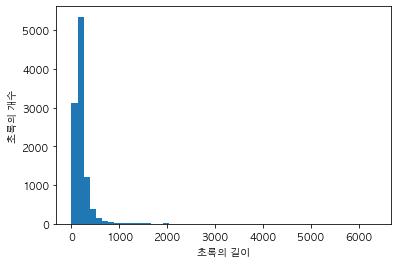

In [12]:
print('초록의 최대 길이:', max(len(l) for l in tokenized_data))
print('초록의 평균 길이:', sum(map(len, tokenized_data)) / len(tokenized_data))

plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('초록의 길이')
plt.ylabel('초록의 개수')
plt.show()

In [13]:
model = Word2Vec(sentences=tokenized_data, size=100, window=5, min_count=5, workers=4, sg=0)

In [14]:
model.wv.vectors.shape

(15120, 100)

In [15]:
print(model.wv.most_similar("자율"))

[('정속', 0.5691282153129578), ('험로', 0.5275231003761292), ('쾌', 0.5181227326393127), ('인공지능', 0.5001052618026733), ('안전', 0.4889315664768219), ('走行', 0.48468345403671265), ('보안', 0.4640912413597107), ('자동', 0.4591635465621948), ('윤리', 0.4581497013568878), ('무인', 0.4476373791694641)]


In [16]:
print(model.wv.most_similar("시뮬레이션"))

[('모델링', 0.9050024747848511), ('테스트', 0.8123716711997986), ('실험', 0.8020768165588379), ('모의실험', 0.7870085835456848), ('최적화', 0.7480729818344116), ('구현', 0.7448224425315857), ('검증', 0.7407007217407227), ('유한요소해석', 0.726791501045227), ('모델', 0.7127584218978882), ('설계', 0.7020149230957031)]


In [58]:
dataset['주제어']

0                                                      NaN
1        Internal Combustion Engine(내연기관),Energy (에너지),...
2        Hydrogen Fuel Cell Vehicle(수소 연료전지 자동차),Crash ...
3        HOOD(본넷트),Distance(이동량),LS-DYNA(구조해석),MOLDFLOW...
4                                                      NaN
                               ...                        
50563    Automotive HAVC System(차량용 공조시스템),Acoustic sca...
50564    FEM(유한요소법),EMC(전자파적합성),Connector(커넥터),Electro-...
50565                                                  NaN
50566    선형탄성파괴역학,소트피닝,압축잔류응력,LEFM,Shot Peening,Compres...
50567                                                  NaN
Name: 주제어, Length: 50568, dtype: object

In [ ]:
dataset['작성언어'].value_counts()

### CountVector를 위한 준비 작업 및 확인 로직 (시작)

In [81]:
#분석대상 항목으로 발행연도, 제목, 주제어, 국문 초록 (Abstract)을 선택하고 컬럼명을 영문으로 변경함
dataset_1 = dataset.loc[:, ['발행연도', '제목', '저자', '발행기관', '학술지명', '주제어', '국문 초록 (Abstract)', '다국어 초록 (Multilingual Abstract)']]
dataset_1 = dataset_1.rename({'발행연도':'year', '제목':'title', '저자':'author', '발행기관':'publisher', '학술지명':'journal', '주제어':'keyword', '국문 초록 (Abstract)':'abstract_old', '다국어 초록 (Multilingual Abstract)':'others'}, axis=1)

In [80]:
dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50568 entries, 0 to 50567
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       50568 non-null  int64 
 1   title      50568 non-null  object
 2   author     50568 non-null  object
 3   publisher  50568 non-null  object
 4   journal    50568 non-null  object
 5   keyword    26933 non-null  object
 6   abstract   28871 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.7+ MB


In [82]:
#국문 초록 값이 없는 건수가 전체의 80%에 해당하고 있음(잘못된 논리임)
#하지만 제목은 초록의 함축적인 문장으로 볼 수 있기 때문에 초록이 없는 경우 제목으로 대체


#0.주제어 예측
#1.가짜 키워드~ 판별....
#2.문서요약
#-키워드 백터
# dataset_2['keyword'].apply(get_words)
dataset_1['abstract'] = np.where(dataset_1['abstract_old'].isnull(), dataset_1['others'], dataset_1['abstract_old'])
#dataset_1['abstract'] = np.where(dataset_1['abstract_old'].isnull(), dataset_1['others'].apply(translate_test), dataset_1['abstract_old'])

del dataset_1['abstract_old']
del dataset_1['others']

dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50568 entries, 0 to 50567
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       50568 non-null  int64 
 1   title      50568 non-null  object
 2   author     50568 non-null  object
 3   publisher  50568 non-null  object
 4   journal    50568 non-null  object
 5   keyword    26933 non-null  object
 6   abstract   28871 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.7+ MB


In [83]:
dataset_2 = dataset_1[dataset_1['abstract'].isnull() == False]

In [84]:
dataset_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28871 entries, 2 to 50566
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       28871 non-null  int64 
 1   title      28871 non-null  object
 2   author     28871 non-null  object
 3   publisher  28871 non-null  object
 4   journal    28871 non-null  object
 5   keyword    18873 non-null  object
 6   abstract   28871 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.8+ MB


In [85]:
stop_words_eng = stopwords.words('english')
stop_words_kor = stopwords.words('korean')

stop_words = []
stop_words.extend(stop_words_kor)
stop_words.extend(stop_words_eng)

stop_words[:5]

['이', '있', '하', '것', '들']

In [86]:
#색인 추출
def tokenizer_by_twitter(raw, pos=["Noun","Alpha","Verb","Number"], stopword=stop_words):
    return [
        word for word, tag in twitter.pos(
            raw, 
            norm=True,   # normalize 그랰ㅋㅋ -> 그래ㅋㅋ
            stem=True    # stemming 바뀌나->바뀌다
            )
            if len(word) > 1 and tag in pos and word not in stopword
    ]
 
#색인 추출
def tokenizer_by_kkma(raw, pos=["NNG","NNP","NP", "VV"], stopword=stop_words):
    return [
        word for word, tag in kkma.pos(raw)
            if len(word) > 1 and tag in pos and word not in stopword
    ]

#색인 추출
def tokenizer_by_mecab(raw, pos=["NNG","NNP","NP", "VV"], stopword=stop_words):
    return [
        word for word, tag in mecab.pos(raw)
            if len(word) > 1 and tag in pos and word not in stopword
    ]

In [122]:
import re

p = re.compile('[ㄱ-하ㅏ-ㅣ가-힣]+')

f = lambda x: p.findall(x)[0].split(",")[0] if len(p.findall(x)) > 0  else print(x)

f(sentence)

dataset_3['author'].apply(f)

Rha Wan Yong
Rha Wan Yong
Rha, Wan Yong
Kyoungjin Kim,Honggi Ko,Jeongmyeong Seo
Seung Bong Hyun,Byeong Yeop Kim,Ji Hun Song,Dong-Ryul Lee
Yun-Tao SONG,Jong-Ho LEE
Seongbeom Lee
Dai, Hao,Zhang, Hao
Jinsoo Park,Jinsoo Choi,Hyunjae Kim,Jun Oh,Minyoung Seong,Joonyoung Ahn,Sangbo Lee,Jeongho Kim
Hyun Soo Bae,Suk Gyu Lee
Dong-Ryul Lee
Insang Song,Junghoon Sin,Chankyu Park,Joonkyu Kim
WANG CHEN
Rha Wan Yong,Yang Heum
Byeong Yeop Kim,Dong-Ryul Lee
Jong Man Park
Kim, Tae-Ho,Lim, Jong-In
Dae-Sung Seo
Hao Dai,Hao Zhang


10       박영환
29       이신재
30       이신재
40        구상
50       전지환
        ... 
50205    이동석
50229    천상욱
50242    김영균
50244    조기훈
50258    송시우
Name: author, Length: 3001, dtype: object

In [123]:
#2018년 이후 논문
dataset_3 = dataset_2[dataset_2['year'] >= 2018]

p = re.compile('[ㄱ-하ㅏ-ㅣ가-힣]+')

#인덱스 reset
dataset_3 = dataset_3.reset_index()
rawdata = dataset_3["abstract"].tolist()

In [124]:
print(len(rawdata))
dataset_3.head()

3001


,index,year,title,author,publisher,journal,keyword,abstract
0,10,2018,[초청강연Ⅱ] 차세대 자동차를 위한 차체 경량화 기술 = Technology of ...,박영환(Young Whan Park),한국자동차공학회,한국자동차공학회 지부 학술대회 논문집,"Light Weight Vehicle(경량 자동차),Multi-Material Ca...","전세계적 환경오염에 대한 관심이 많아 지고 있으며, 이에 대하여 각국은 차량의 배기..."
1,29,2018,미래형자동차 R&D 전문인력양성 = 현장실습 및 산업체 수요 중심으로,"이신재(Sinjae Lee),김진하(Jinha Kim),기석철(Seok-Cheol ...",한국자동차공학회,한국자동차공학회 부문종합 학술대회,"Future Cars(미래형자동차),Human Resource Training(인력...",미래형 자동차 관련 핵심기술은 단순히 전통적인 자동차 분야에서 벗어나 역할의 중요성...
2,30,2018,자율주행 자동차용 임베디드 소프트웨어,"이신재(Sinjae Lee),김진하(Jinha Kim),기석철(Seok-Cheol ...",한국자동차공학회,한국자동차공학회 부문종합 학술대회,"Embedded Software(임베디드 소프트웨어),Autonomous Drivi...","자율주행 자동차는 인공지능에 의한 인지, 센서, 측위 그리고 제어의 융합인 자율주행..."
3,40,2018,자동차 디자인 변화와 자동차산업의 지역 이동 비교 연구,구상(Sang Koo),한국자동차공학회,한국 자동차공학회논문집(Transactions of Korea Society of ...,"Design changing factors(디자인 변화 요인),Vehicle tec...",Automobile designs have been changed by multif...
4,50,2019,저온 특성을 반영한 등가 회로 기반 48V 마일드 하이브리드 자동차 동적 배터리 모...,"전지환(Jeehwan Jeon),노정우(Jungwoo Noh),김원태(Wontae ...",한국자동차공학회,한국자동차공학회 부문종합 학술대회,"Electrification(전동화),Equivalent Circuit Model ...",48V 마일드 하이브리드 자동차의 연비 및 동력 성능 개선을 위해 기존 기계부품의 ...


In [125]:
import time
start = time.time()

vect = CountVectorizer(min_df=0.1, tokenizer=tokenizer_by_mecab)
result = vect.fit_transform(rawdata)
print(
    'fit_transform, (sentence {}, feature {})'.format(result.shape[0], result.shape[1])
)

end = time.time()
print(f'총 소요시간: {end-start}초')

fit_transform, (sentence 3001, feature 37)
총 소요시간: 5.502478122711182초


In [126]:
vect.vocabulary_

{'환경': 34,
 '차량': 29,
 '자동차': 20,
 '진행': 28,
 '필요': 32,
 '효과': 36,
 '적용': 22,
 '기술': 5,
 '기존': 6,
 '방법': 11,
 '특성': 31,
 '가능': 0,
 '발생': 10,
 '연구': 17,
 '분석': 13,
 '활용': 35,
 '결과': 2,
 '산업': 15,
 '관련': 3,
 '중요': 26,
 '시스템': 16,
 '기반': 4,
 '개발': 1,
 '논문': 7,
 '자율': 21,
 '주행': 25,
 '이용': 19,
 '사용': 14,
 '목적': 9,
 '증가': 27,
 '영향': 18,
 '변화': 12,
 '확인': 33,
 '최근': 30,
 '제시': 23,
 '제안': 24,
 '대상': 8}

In [127]:
result.todense()

matrix([[ 1,  0,  1, ...,  1,  1,  1],
        [ 0,  1,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  2],
        [ 1,  0,  0, ...,  2, 17,  1]])

In [128]:
# 문장에서 뽑아낸 feature 들의 Dictionary
features = vect.get_feature_names()
print(features)

['가능', '개발', '결과', '관련', '기반', '기술', '기존', '논문', '대상', '목적', '발생', '방법', '변화', '분석', '사용', '산업', '시스템', '연구', '영향', '이용', '자동차', '자율', '적용', '제시', '제안', '주행', '중요', '증가', '진행', '차량', '최근', '특성', '필요', '확인', '환경', '활용', '효과']


In [129]:
print(len(result.toarray()))

3001


In [130]:
result_frame = pd.DataFrame(result_array, columns=features)
result_frame

,가능,개발,결과,관련,기반,기술,기존,논문,대상,목적,...,증가,진행,차량,최근,특성,필요,확인,환경,활용,효과
0,1,0,1,0,0,3,1,0,0,0,...,0,1,1,0,1,2,0,1,1,1
1,0,1,0,1,2,4,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,1,0,1,...,0,0,3,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,0,0,2,0,1,0,0,0,...,1,2,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,2


In [131]:
last_result = pd.concat([dataset_3, result_frame.reindex(dataset_3.index)], axis = 1)
last_result

,index,year,title,author,publisher,journal,keyword,abstract,가능,개발,...,증가,진행,차량,최근,특성,필요,확인,환경,활용,효과
0,10,2018,[초청강연Ⅱ] 차세대 자동차를 위한 차체 경량화 기술 = Technology of ...,박영환(Young Whan Park),한국자동차공학회,한국자동차공학회 지부 학술대회 논문집,"Light Weight Vehicle(경량 자동차),Multi-Material Ca...","전세계적 환경오염에 대한 관심이 많아 지고 있으며, 이에 대하여 각국은 차량의 배기...",1,0,...,0,1,1,0,1,2,0,1,1,1
1,29,2018,미래형자동차 R&D 전문인력양성 = 현장실습 및 산업체 수요 중심으로,"이신재(Sinjae Lee),김진하(Jinha Kim),기석철(Seok-Cheol ...",한국자동차공학회,한국자동차공학회 부문종합 학술대회,"Future Cars(미래형자동차),Human Resource Training(인력...",미래형 자동차 관련 핵심기술은 단순히 전통적인 자동차 분야에서 벗어나 역할의 중요성...,0,1,...,0,0,0,0,0,0,0,0,0,0
2,30,2018,자율주행 자동차용 임베디드 소프트웨어,"이신재(Sinjae Lee),김진하(Jinha Kim),기석철(Seok-Cheol ...",한국자동차공학회,한국자동차공학회 부문종합 학술대회,"Embedded Software(임베디드 소프트웨어),Autonomous Drivi...","자율주행 자동차는 인공지능에 의한 인지, 센서, 측위 그리고 제어의 융합인 자율주행...",0,0,...,0,0,3,0,0,0,0,0,0,0
3,40,2018,자동차 디자인 변화와 자동차산업의 지역 이동 비교 연구,구상(Sang Koo),한국자동차공학회,한국 자동차공학회논문집(Transactions of Korea Society of ...,"Design changing factors(디자인 변화 요인),Vehicle tec...",Automobile designs have been changed by multif...,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,2019,저온 특성을 반영한 등가 회로 기반 48V 마일드 하이브리드 자동차 동적 배터리 모...,"전지환(Jeehwan Jeon),노정우(Jungwoo Noh),김원태(Wontae ...",한국자동차공학회,한국자동차공학회 부문종합 학술대회,"Electrification(전동화),Equivalent Circuit Model ...",48V 마일드 하이브리드 자동차의 연비 및 동력 성능 개선을 위해 기존 기계부품의 ...,0,3,...,1,2,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,50205,2019,깊이 정보로 평면 유사도 측정을 통한 자동차 번호판 검출 방법 = Vehicle P...,"이동석,권순각",한국산업정보학회,한국산업정보학회논문지(Journal of the Korea industrial in...,"Depth Information,Vehicle Plate Detection,Plan...",본 논문에서는 조명의 영향을 받지 않는 깊이 정보를 이용한 번호판 검출 방법을 제안...,0,0,...,0,0,0,0,0,0,0,0,0,0
2997,50229,2020,참조 모델과 설계 이력 데이터를 이용한 자동차 기구 요소의 지식 기반 설계 시스템 ...,천상욱,대한설비관리학회,대한설비관리학회지(JOURNAL OF THE KOREAN INSTITUTE OF P...,"CAD Model,Design History,XpertRule,Ontology,Kn...",Reusing existing design data in product design...,0,0,...,0,0,0,0,0,0,0,0,0,0
2998,50242,2018,산화물 분산 강화 강 분말이 첨가된 자동차 부품용 철계 복합 소재의 미세조직 및 마...,"김영균,박종관,이기안,Kim, Young-Kyun,Park, Jong-Kwan,Le...",한국분말야금학회,한국분말야금학회지(Journal of Korean powder metallurgy ...,"Oxide dispersion strengthening,Steel-base comp...",In order to expand the application of oxide di...,0,0,...,0,0,0,0,0,0,0,0,0,0
2999,50244,2018,스마트 기업의 BCMS 도입이 조직 인식구조 변화에 미친 영향에 관한 연구 (자동차...,"조기훈,김동헌,장호진,Cho, Ki Hoon,Kim, Dong Heon,Jang, ...",한국방재안전학회,한국방재안전학회 논문집(Korean Society of Disaster & Secu...,"비즈니스연속성관리시스템,조직의 인식구조,비상사태","비즈니스 연속성에 치명적인 영향을 줄 수 있는 홍수, 호우, 강풍 등 자연재해와 9...",0,0,...,0,0,0,0,0,2,0,0,0,2


In [132]:
dataset_3.to_csv("./dataset/count_vec.csv", index=False, encoding="utf-8")

In [133]:
vectorize = TfidfVectorizer(
    tokenizer=tokenizer_by_mecab,
    min_df=5,
    sublinear_tf = True    # tf값에 1+log(tf)를 적용하여 tf값이 무한정 커지는 것을 막음
)
X = vectorize.fit_transform(rawdata)
print(
    'fit_transform, (sentence {}, feature {})'.format(X.shape[0], X.shape[1])
)
print(X.toarray())
# 문장에서 뽑아낸 feature 들의 배열
features = vectorize.get_feature_names()

fit_transform, (sentence 3001, feature 3075)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [135]:
print(X.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### CountVector를 위한 준비 작업 및 확인 로직 (종료)

In [78]:
result = []

for idx, val in enumerate(rawdata):
        if idx % 1000 == 0 :
        print(f'{idx + 1} 개를 처리중입니다. [{val}]')
    words = tokenizer_by_kkma(val)
    result.extend(words)

In [87]:
len(result)

160764

In [88]:
count = Counter(result)

In [96]:
words = dict(count.most_common(100))
print(words)


{'자동차': 4123, '시스템': 2152, '차량': 1782, '해석': 1610, '주행': 1602, '제어': 1473, '장치': 1278, '전기': 1113, '시험': 1054, '연료': 1042, '모델': 965, '자율': 927, '엔진': 891, '분석': 865, '요소': 862, '가스': 726, '충돌': 712, '하이브리드': 655, '설계': 654, '센서': 638, '평가': 617, '분사': 602, '안전': 551, '성능': 547, '산업': 543, '보험': 537, '특성': 528, '구조': 514, '모드': 508, '모터': 504, '촉매': 494, '도로': 490, '변속기': 484, '조향': 482, '자동': 479, '디젤': 476, '최적화': 472, '제동': 468, '유체': 444, '환경': 434, '배출': 431, '교통': 431, '전산': 430, '전지': 429, '토크': 425, '계수': 410, '역학': 410, '에너지': 401, '시뮬레이션': 400, '배터리': 397, '압력': 392, '복합': 390, '물질': 389, '질소': 388, '밸브': 382, '산화물': 379, '운전자': 379, '속도': 374, '마찰': 369, '클러치': 360, '책임': 360, '부품': 357, '디자인': 356, '소음': 348, '연소': 348, '운전': 343, '기술': 340, '브레이크': 338, '사고': 330, '시간': 327, '전자': 326, '수소': 323, '모형': 322, '구동': 315, '시트': 310, '동역학': 308, '최적': 299, '모듈': 295, '전략': 293, '공기': 292, '온도': 291, '실험': 291, '냉각': 290, '가솔린': 290, '강도': 281, '기반': 278, '정보': 277, '펌프': 274, '

In [97]:
words = dict(count.most_common(200))
print(words)

{'자동차': 4123, '시스템': 2152, '차량': 1782, '해석': 1610, '주행': 1602, '제어': 1473, '장치': 1278, '전기': 1113, '시험': 1054, '연료': 1042, '모델': 965, '자율': 927, '엔진': 891, '분석': 865, '요소': 862, '가스': 726, '충돌': 712, '하이브리드': 655, '설계': 654, '센서': 638, '평가': 617, '분사': 602, '안전': 551, '성능': 547, '산업': 543, '보험': 537, '특성': 528, '구조': 514, '모드': 508, '모터': 504, '촉매': 494, '도로': 490, '변속기': 484, '조향': 482, '자동': 479, '디젤': 476, '최적화': 472, '제동': 468, '유체': 444, '환경': 434, '배출': 431, '교통': 431, '전산': 430, '전지': 429, '토크': 425, '계수': 410, '역학': 410, '에너지': 401, '시뮬레이션': 400, '배터리': 397, '압력': 392, '복합': 390, '물질': 389, '질소': 388, '밸브': 382, '산화물': 379, '운전자': 379, '속도': 374, '마찰': 369, '클러치': 360, '책임': 360, '부품': 357, '디자인': 356, '소음': 348, '연소': 348, '운전': 343, '기술': 340, '브레이크': 338, '사고': 330, '시간': 327, '전자': 326, '수소': 323, '모형': 322, '구동': 315, '시트': 310, '동역학': 308, '최적': 299, '모듈': 295, '전략': 293, '공기': 292, '온도': 291, '실험': 291, '냉각': 290, '가솔린': 290, '강도': 281, '기반': 278, '정보': 277, '펌프': 274, '

In [106]:
dataset_5 = dataset_5.dropna()
for word in words :
    count = len(dataset_5[dataset_5['abstract'].str.contains(word)])
    print(f'주제어: {word} / 논문수: {count}')

주제어: 자동차 / 논문수: 5604
주제어: 시스템 / 논문수: 1377
주제어: 차량 / 논문수: 1393
주제어: 해석 / 논문수: 713
주제어: 주행 / 논문수: 939
주제어: 제어 / 논문수: 515
주제어: 장치 / 논문수: 629
주제어: 전기 / 논문수: 802
주제어: 시험 / 논문수: 430
주제어: 연료 / 논문수: 403
주제어: 모델 / 논문수: 810
주제어: 자율 / 논문수: 532
주제어: 엔진 / 논문수: 329
주제어: 분석 / 논문수: 2910
주제어: 요소 / 논문수: 800
주제어: 가스 / 논문수: 470
주제어: 충돌 / 논문수: 162
주제어: 하이브리드 / 논문수: 149
주제어: 설계 / 논문수: 966
주제어: 센서 / 논문수: 277
주제어: 평가 / 논문수: 1038
주제어: 분사 / 논문수: 54
주제어: 안전 / 논문수: 908
주제어: 성능 / 논문수: 893
주제어: 산업 / 논문수: 1558
주제어: 보험 / 논문수: 349
주제어: 특성 / 논문수: 1369
주제어: 구조 / 논문수: 988
주제어: 모드 / 논문수: 112
주제어: 모터 / 논문수: 144
주제어: 촉매 / 논문수: 91
주제어: 도로 / 논문수: 1021
주제어: 변속기 / 논문수: 52
주제어: 조향 / 논문수: 61
주제어: 자동 / 논문수: 5653
주제어: 디젤 / 논문수: 107
주제어: 최적화 / 논문수: 197
주제어: 제동 / 논문수: 94
주제어: 유체 / 논문수: 47
주제어: 환경 / 논문수: 1495
주제어: 배출 / 논문수: 414
주제어: 교통 / 논문수: 894
주제어: 전산 / 논문수: 63
주제어: 전지 / 논문수: 234
주제어: 토크 / 논문수: 73
주제어: 계수 / 논문수: 192
주제어: 역학 / 논문수: 77
주제어: 에너지 / 논문수: 516
주제어: 시뮬레이션 / 논문수: 309
주제어: 배터리 / 논문수: 173
주제어: 압력 / 논문수: 190
주제어: 복합 / 논문수: 293

In [ ]:
#키워드 를 축소 필요 
#키워드별로 논문 개수 (논문편수 5개 이하는 제외하자)
#https://codechacha.com/ko/python-google-translate/

- from googletrans import Translator
- translator = Translator()
- result = translator.translate('안녕하세요.', dest="ja")
- print(result[0].text)

#### 구글 번역 API가 변경되어 다음과 같은 설치 필요

- $ pip uninstall googletrans
- $ git clone https://github.com/alainrouillon/py-googletrans.git
- $ cd ./py-googletrans
- $ git checkout origin/feature/enhance-use-of-direct-api
- $ python setup.py install

In [ ]:
#1.주제어 COUNT
#2.분석대상 명확하게~ 
#3.주제어별 관계도